### Evolution of Breaches Over Time

In [1]:
import pandas as pd
import numpy as np
import janitor
from datetime import datetime
from typing import List, Set
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from IPython.core.display import HTML
from IPython.display import display
import sys

sys.path.append("/home/lsys/pwned_pols/venv/lib/python3.10/site-packages")
from utilities import save_mpl_fig
import warnings

warnings.filterwarnings("ignore")

## Emails

In [2]:
df_emails = (
    pd.read_csv(
        "../data/email_lvl_cov.csv",
        usecols=["email", "source", "cc3", "leg_start_date", "leg_start_year"],
    )
    # Fix sg dates
    .assign(
        leg_start_date=lambda df: np.where(
            df["cc3"] == "SGP",
            df["leg_start_year"].map(
                {
                    2021: "2020-08-24",
                    2016: "2016-01-15",
                    2011: "2011-10-10",
                    2006: "2006-11-02",
                    2001: "2002-03-25",
                }
            ),
            df["leg_start_date"],
        )
    )
    .dropna(subset=["leg_start_date"], ignore_index=True)
    .assign(leg_start_date=lambda df_: pd.to_datetime(df_["leg_start_date"]))
)
latest_leg_start_date = df_emails["leg_start_date"].max()
print(latest_leg_start_date.date())
print(df_emails["leg_start_date"].nunique())
df_emails

ValueError: Usecols do not match columns, columns expected but not found: ['leg_start_date']

In [3]:
# Get all dates
dates_ts = pd.date_range(
    start=df_emails["leg_start_date"].min(), end=pd.Timestamp("2025-02-01"), freq="D"
)
dates_ts

DatetimeIndex(['1997-05-01', '1997-05-02', '1997-05-03', '1997-05-04',
               '1997-05-05', '1997-05-06', '1997-05-07', '1997-05-08',
               '1997-05-09', '1997-05-10',
               ...
               '2025-01-23', '2025-01-24', '2025-01-25', '2025-01-26',
               '2025-01-27', '2025-01-28', '2025-01-29', '2025-01-30',
               '2025-01-31', '2025-02-01'],
              dtype='datetime64[ns]', length=10139, freq='D')

In [4]:
def emails_active_on(d: datetime, dataframe=df_emails) -> List[str]:
    """
    Retrieve a list of emails active on or after a given date.

    Parameters:
    d (pd.Timestamp): The date to check against 'leg_start_date'.

    Returns:
    List[str]: A list of email addresses active on or before the given date.

    Notes:
    - Uses 'leg_start_date' as the threshold.
    - Compares dates using '≤' (less than or equal to), meaning emails
      with a start date on or before 'd' are considered active.
    """
    return dataframe.loc[df_emails["leg_start_date"] <= d, "email"].tolist()

In [5]:
# init TS of cumulative emails and breaches
df_dates = (
    pd.DataFrame({"date": dates_ts})
    .assign(emails=lambda df_: df_["date"].apply(emails_active_on))
    .assign(n_emails=lambda df_: df_["emails"].apply(len))
)
df_dates

,date,emails,n_emails
0,1997-05-01,"[alan.campbell.mp@parliament.uk, alan.duncan.m...",117
1,1997-05-02,"[alan.campbell.mp@parliament.uk, alan.duncan.m...",117
2,1997-05-03,"[alan.campbell.mp@parliament.uk, alan.duncan.m...",117
3,1997-05-04,"[alan.campbell.mp@parliament.uk, alan.duncan.m...",117
4,1997-05-05,"[alan.campbell.mp@parliament.uk, alan.duncan.m...",117
...,...,...,...
10134,2025-01-28,"[albana.vokshi@parlament.al, aldo.bumci@parlam...",9200
10135,2025-01-29,"[albana.vokshi@parlament.al, aldo.bumci@parlam...",9200
10136,2025-01-30,"[albana.vokshi@parlament.al, aldo.bumci@parlam...",9200
10137,2025-01-31,"[albana.vokshi@parlament.al, aldo.bumci@parlam...",9200


## HIBP

In [6]:
df_hibp = (
    pd.concat(
        [
            pd.read_csv("../data/everypol_hibp.csv"),
            pd.read_csv("../data/scraped_pol_hibp.csv"),
        ],
        ignore_index=True,
    )
    .clean_names()
    .query("present==True")
    .remove_columns("present")
    .rename_column("filename", "email")
    .sort_values(["email"], ignore_index=True)
    # =============================================================
    .merge(
        (
            pd.read_csv("../data/breaches_01_2025.csv")
            .clean_names()
            .rename_column("name", "breach")
            #             .filter(["breach", "breachdate", "addeddate"])
            .filter(["breach", "breachdate"])
            #             .rename_column("breachdate")
        ),
        how="left",
        on="breach",
        validate="m:1",
    )
    # =============================================================
    .assign(breachdate=lambda df_: pd.to_datetime(df_["breachdate"]))
)
df_hibp

,email,breach,breachdate
0,123@abc.com,VNG,2015-05-19
1,123@abc.com,VerificationsIO,2019-02-25
2,123@abc.com,Stratfor,2011-12-24
3,123@abc.com,Lastfm,2012-03-22
4,123@abc.com,Zomato,2017-05-17
...,...,...,...
14316,zmakhubele@parliament.gov.za,LinkedInScrape,2021-04-08
14317,zoltan.tessely@parlament.hu,Cit0day,2020-11-04
14318,zrantho@parliament.gov.za,db8151dd,2020-02-20
14319,zuzana_zimenova@nrsr.sk,PDL,2019-10-16


In [7]:
# get earliest breach date per email
df_earliest = (
    df_hibp.groupby("email", as_index=False)["breachdate"]
    .min()
    .rename(columns={"breachdate": "earliest_breachdate"})
)
earliest_dict = dict(zip(df_earliest["email"], df_earliest["earliest_breachdate"]))
df_earliest.head()

,email,earliest_breachdate
0,123@abc.com,2007-07-12
1,123@gmail.com,2008-07-01
2,2016kimss@gmail.com,2021-09-13
3,2ashokrai@gmail.com,2016-10-08
4,2yangs6288@naver.com,2024-05-28


In [8]:
def breached_before(d: datetime, day_emails: Set[str]) -> List[str]:
    """
    Identify emails from a given day's list that had a known breach before that day.

    Args:
        d (datetime): The reference date.
        day_emails (Set[str]): A set of emails active on this date.

    Returns:
        List[str]: A list of emails that had a breach before this date.
    """
    breached = []
    for e in day_emails:
        if e in earliest_dict and earliest_dict[e] < d:
            breached.append(e)
    return breached

In [9]:
df_dates["breached_emails"] = df_dates.apply(
    lambda row: breached_before(row["date"], row["emails"]), axis=1
)
df_dates["n_breached_emails"] = df_dates["breached_emails"].apply(len)
df_dates["pr"] = df_dates["n_breached_emails"] / df_dates["n_emails"]
df_dates["pr_diff"] = df_dates["pr"].diff()
df_dates = df_dates.query("date>'2008-01-01'")

df_dates

,date,emails,n_emails,breached_emails,n_breached_emails,pr,pr_diff
3898,2008-01-02,"[a.albanese.mp@aph.gov.au, andrew.laming.mp@ap...",844,[],0,0.000000,0.0
3899,2008-01-03,"[a.albanese.mp@aph.gov.au, andrew.laming.mp@ap...",844,[],0,0.000000,0.0
3900,2008-01-04,"[a.albanese.mp@aph.gov.au, andrew.laming.mp@ap...",844,[],0,0.000000,0.0
3901,2008-01-05,"[a.albanese.mp@aph.gov.au, andrew.laming.mp@ap...",844,[],0,0.000000,0.0
3902,2008-01-06,"[a.albanese.mp@aph.gov.au, andrew.laming.mp@ap...",844,[],0,0.000000,0.0
...,...,...,...,...,...,...,...
10134,2025-01-28,"[albana.vokshi@parlament.al, aldo.bumci@parlam...",9200,"[edmond.spaho@parlament.al, pepbardina@gmail.c...",3031,0.329457,0.0
10135,2025-01-29,"[albana.vokshi@parlament.al, aldo.bumci@parlam...",9200,"[edmond.spaho@parlament.al, pepbardina@gmail.c...",3031,0.329457,0.0
10136,2025-01-30,"[albana.vokshi@parlament.al, aldo.bumci@parlam...",9200,"[edmond.spaho@parlament.al, pepbardina@gmail.c...",3031,0.329457,0.0
10137,2025-01-31,"[albana.vokshi@parlament.al, aldo.bumci@parlam...",9200,"[edmond.spaho@parlament.al, pepbardina@gmail.c...",3031,0.329457,0.0


In [10]:
# Prep hibp datat to get cumulative n_breachs
df_hibp = (
    pd.read_csv("../data/breaches_01_2025.csv")
    .clean_names()
    .filter(["name", "description", "breachdate", "addeddate", "dataclasses"])
    .assign(breachdate=lambda df_: pd.to_datetime(df_["breachdate"]))
)
df_hibp

,name,description,breachdate,addeddate,dataclasses
0,000webhost,"In approximately March 2015, the free web host...",2015-03-01,2015-10-26T23:35:45Z,"['Email addresses', 'IP addresses', 'Names', '..."
1,123RF,"In March 2020, the stock photo site <a href=""h...",2020-03-22,2020-11-15T00:59:50Z,"['Email addresses', 'IP addresses', 'Names', '..."
2,126,"In approximately 2012, it's alleged that the C...",2012-01-01,2016-10-08T07:46:05Z,"['Email addresses', 'Passwords']"
3,17Media,"In April 2016, customer data obtained from the...",2016-04-19,2016-07-08T01:55:03Z,"['Device information', 'Email addresses', 'IP ..."
4,17173,"In late 2011, <a href=""https://news.softpedia....",2011-12-28,2018-04-28T04:53:15Z,"['Email addresses', 'Passwords', 'Usernames']"
...,...,...,...,...,...
852,Zurich,"In January 2023, <a href=""https://therecord.me...",2023-01-08,2023-01-22T22:30:56Z,"['Dates of birth', 'Email addresses', 'Genders..."
853,Zynga,"In September 2019, game developer <a href=""htt...",2019-09-01,2019-12-19T04:54:45Z,"['Email addresses', 'Passwords', 'Phone number..."
854,Parapa,"In August 2016, <a href=""http://www.zdnet.com/...",2016-08-08,2016-12-28T07:03:17Z,"['Email addresses', 'Passwords', 'Usernames']"
855,SprashivaiRu,"In May 2015, <a href=""http://sprashivai.ru/"" t...",2015-05-11,2015-05-12T23:50:08Z,"['Dates of birth', 'Email addresses', 'Genders..."


In [11]:
# get cumulative n_breachs
df_hibp_dates = (
    pd.DataFrame({"date": dates_ts})
    .assign(
        n_breaches=lambda df: df["date"].apply(
            lambda d: (df_hibp["breachdate"] <= d).sum()
        )
    )
    .query("date>'2008-01-01'")
)
df_hibp_dates

,date,n_breaches
3898,2008-01-02,1
3899,2008-01-03,1
3900,2008-01-04,1
3901,2008-01-05,1
3902,2008-01-06,1
...,...,...
10134,2025-01-28,857
10135,2025-01-29,857
10136,2025-01-30,857
10137,2025-01-31,857


## Plot

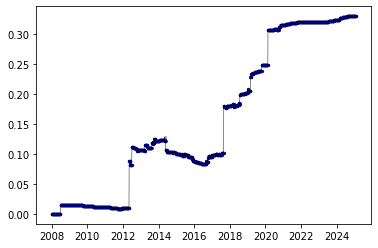

In [12]:
plt.plot(df_dates["date"], df_dates["pr"], color="0", linestyle="-", lw=0.5, alpha=0.9)
plt.scatter(df_dates["date"], df_dates["pr"], color="navy", s=5, marker="o", alpha=0.3)

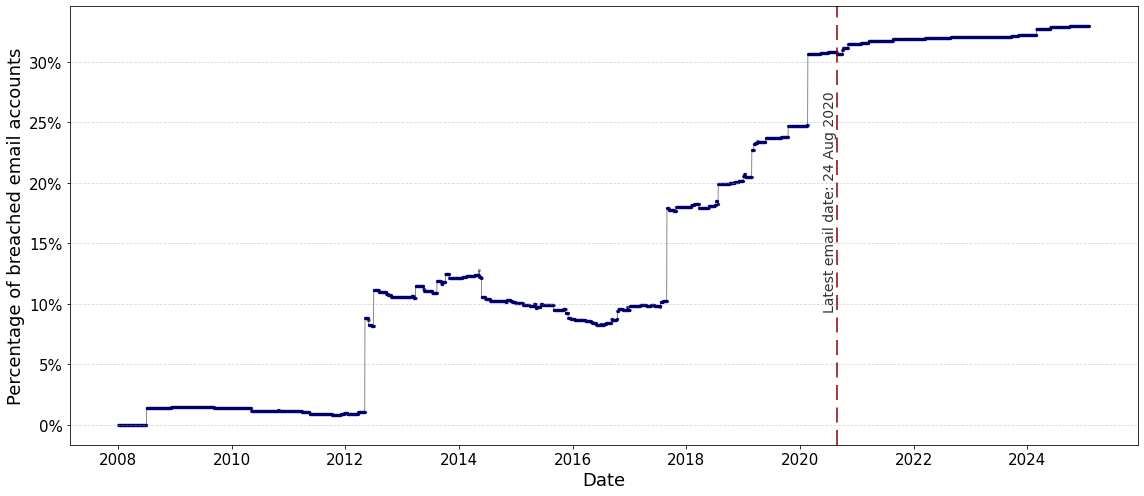

In [13]:
_scale = 1
_aspect_ratio = (16, 7)
figsize = tuple(k * _scale for k in _aspect_ratio)
_, ax = plt.subplots(figsize=figsize)

plt.plot(df_dates["date"], df_dates["pr"], color="0", linestyle="-", lw=0.5, alpha=0.9)
plt.scatter(df_dates["date"], df_dates["pr"], color="navy", s=5, marker="o", alpha=0.3)

# ============================================================================
formatted_leg_start_date = latest_leg_start_date.strftime("%d %b %Y")

ax.axvline(
    x=latest_leg_start_date, color="maroon", linestyle=(0, (10, 5)), linewidth=1.5
)
ax.text(
    latest_leg_start_date,
    ax.get_ylim()[1] * 0.8,
    f"Latest email date: {formatted_leg_start_date}",
    color=".2",
    fontsize=14,
    rotation=90,
    ha="right",
    va="top",
)

# ============================================================================


def percentage_formatter(x, pos):
    # Convert proportion to percentage format
    return f"{x:.0%}"


ax.yaxis.set_major_formatter(ticker.FuncFormatter(percentage_formatter))

# ============================================================================
# Labels and grid styling
plt.xlabel("Date", fontsize=18)
plt.ylabel("Percentage of breached email accounts", fontsize=18)
ax.tick_params(axis="both", labelsize=15)
ax.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()

In [14]:
top_jumps = df_dates.nlargest(5, "pr_diff")
top_jumps

,date,emails,n_emails,breached_emails,n_breached_emails,pr,pr_diff
5484,2012-05-06,"[albana.vokshi@parlament.al, aldo.bumci@parlam...",2112,"[andrew.laming.mp@aph.gov.au, steven.ciobo.mp@...",187,0.088542,0.077872
7425,2017-08-29,"[albana.vokshi@parlament.al, aldo.bumci@parlam...",8430,"[rgilicasals@gmail.com, andrew.laming.mp@aph.g...",1512,0.179359,0.077343
8331,2020-02-21,"[albana.vokshi@parlament.al, aldo.bumci@parlam...",9102,"[pepbardina@gmail.com, rgilicasals@gmail.com, ...",2787,0.306196,0.058668
5541,2012-07-02,"[albana.vokshi@parlament.al, aldo.bumci@parlam...",2301,"[andrew.laming.mp@aph.gov.au, steven.ciobo.mp@...",256,0.111256,0.029552
7971,2019-02-26,"[albana.vokshi@parlament.al, aldo.bumci@parlam...",9067,"[pepbardina@gmail.com, rgilicasals@gmail.com, ...",2062,0.227418,0.022499


In [15]:
df_hibp.query("breachdate=='2012-05-05'")

,name,description,breachdate,addeddate,dataclasses
423,LinkedIn,"In May 2016, <a href=""https://www.troyhunt.com...",2012-05-05,2016-05-21T21:35:40Z,"['Email addresses', 'Passwords']"


In [16]:
df_hibp.query("breachdate=='2017-08-28'")

,name,description,breachdate,addeddate,dataclasses
541,OnlinerSpambot,"In August 2017, a spambot by the name of <a hr...",2017-08-28,2017-08-29T19:25:56Z,"['Email addresses', 'Passwords']"


In [17]:
df_hibp.query("breachdate=='2020-02-20'")

,name,description,breachdate,addeddate,dataclasses
158,db8151dd,"In February 2020, <a href=""https://www.troyhun...",2020-02-20,2020-05-15T08:06:11Z,"['Email addresses', 'Job titles', 'Names', 'Ph..."


In [18]:
df_hibp.query("breachdate=='2012-07-01'")

,name,description,breachdate,addeddate,dataclasses
195,Disqus,"In October 2017, the blog commenting service <...",2012-07-01,2017-10-06T23:03:51Z,"['Email addresses', 'Passwords', 'Usernames']"
208,Dropbox,"In mid-2012, Dropbox suffered a data breach wh...",2012-07-01,2016-08-31T00:19:19Z,"['Email addresses', 'Passwords']"


In [19]:
df_hibp.query("breachdate=='2019-02-25'")

,name,description,breachdate,addeddate,dataclasses
782,VerificationsIO,"In February 2019, the email address validation...",2019-02-25,2019-03-09T19:29:54Z,"['Dates of birth', 'Email addresses', 'Employe..."


In [20]:
display(HTML(df_hibp.query("name=='db8151dd'")["description"].values[0]))

In [21]:
display(HTML(df_hibp.query("name=='LinkedIn'")["description"].values[0]))

In [22]:
df_hibp.query("name=='LinkedIn'")["dataclasses"].values[0]

"['Email addresses', 'Passwords']"

In [23]:
display(HTML(df_hibp.query("name=='db8151dd'")["description"].values[0]))

In [24]:
df_hibp.query("name=='db8151dd'")["dataclasses"].values[0]

"['Email addresses', 'Job titles', 'Names', 'Phone numbers', 'Physical addresses', 'Social media profiles']"

In [25]:
display(HTML(df_hibp.query("name=='Disqus'")["description"].values[0]))

In [26]:
display(HTML(df_hibp.query("name=='Dropbox'")["description"].values[0]))

In [27]:
display(HTML(df_hibp.query("name=='VerificationsIO'")["description"].values[0]))

In [28]:
display(HTML(df_hibp.query("name=='OnlinerSpambot'")["description"].values[0]))

In [29]:
df_hibp.query("name=='OnlinerSpambot'")["dataclasses"].values[0]

"['Email addresses', 'Passwords']"

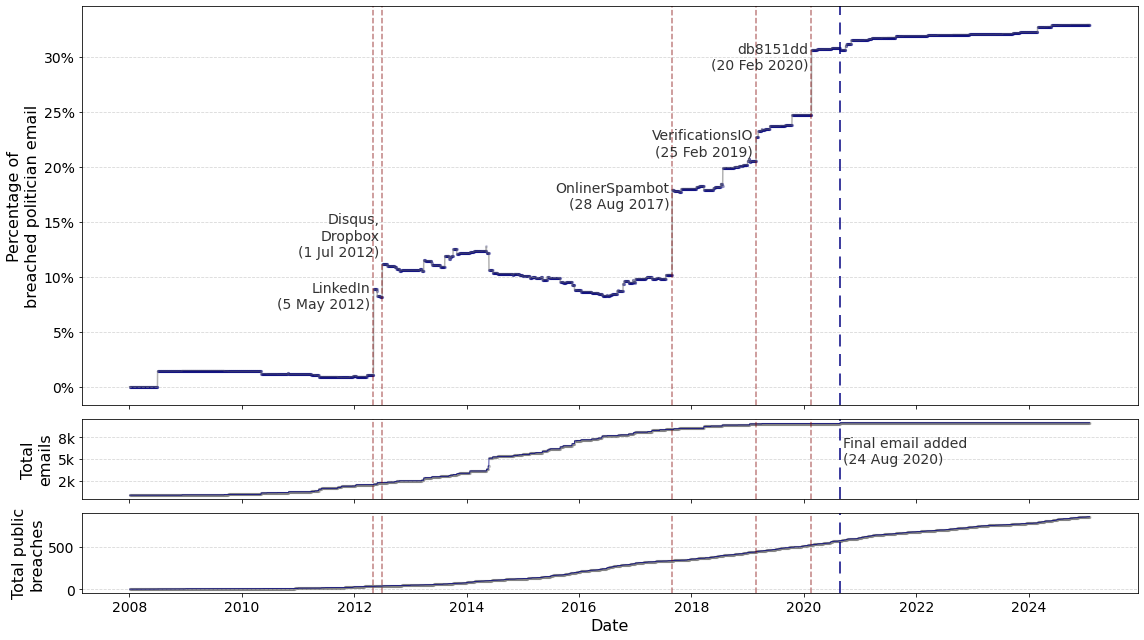

In [47]:
# Create a figure with three panels (sharing x-axis)
_scale = 1
_aspect_ratio = (16, 9)
figsize = tuple(k * _scale for k in _aspect_ratio)
fig, (ax1, ax2, ax3) = plt.subplots(
    3, 1, figsize=figsize, sharex=True, gridspec_kw={"height_ratios": [5, 1, 1]}
)

LABSIZE = 16
TICKERSIZE = 14
ANNOTESIZE = 14

# ============================================================================
# PANEL A
ax1.plot(
    df_dates["date"], df_dates["pr"], color="0.4", linestyle="-", lw=1.5, alpha=0.5
)
ax1.scatter(df_dates["date"], df_dates["pr"], color="navy", s=5, marker="o", alpha=0.1)

ax1.yaxis.set_major_formatter(ticker.FuncFormatter(percentage_formatter))
ax1.set_ylabel("Percentage of\nbreached accounts", fontsize=LABSIZE)
ax1.tick_params(axis="both", labelsize=TICKERSIZE)
ax1.grid(axis="y", linestyle="--", alpha=0.5)

# ============================================================================
# PANEL B
ax2.plot(
    df_dates["date"],
    df_dates["n_emails"],
    color="navy",
    linestyle="-",
    lw=0.8,
    alpha=0.9,
)
ax2.scatter(
    df_dates["date"], df_dates["n_emails"], color=".5", s=5, marker="o", alpha=0.1
)

# Label for second panel
ax2.set_ylabel("Total\nemails", fontsize=LABSIZE)
ax2.tick_params(axis="both", labelsize=TICKERSIZE)
ax2.grid(axis="y", linestyle="--", alpha=0.5)


def thousands_formatter(x, pos):
    # Adds comma separator for thousands
    #     return f"{x:,.0f}"
    # Converts to thousands with 'k' suffix
    return f"{x / 1_000:.0f}k"


ax2.yaxis.set_major_formatter(ticker.FuncFormatter(thousands_formatter))

# ============================================================================
# PANEL C
ax3.plot(
    df_hibp_dates["date"],
    df_hibp_dates["n_breaches"],
    color="navy",
    linestyle="-",
    lw=0.8,
    alpha=0.9,
)
ax3.scatter(
    df_hibp_dates["date"],
    df_hibp_dates["n_breaches"],
    color=".5",
    s=5,
    marker="o",
    alpha=0.1,
)

ax3.set_ylabel("Total public\nbreaches", fontsize=LABSIZE)
ax3.tick_params(axis="both", labelsize=TICKERSIZE)
ax3.grid(axis="y", linestyle="--", alpha=0.5)

# ============================================================================
# Annotate last email date
formatted_leg_start_date = latest_leg_start_date.strftime("%d %b %Y")

_LINESTYLE = dict(
    x=latest_leg_start_date, color="navy", linestyle=(0, (8, 5)), linewidth=1.5
)
ax1.axvline(**_LINESTYLE)
ax2.axvline(**_LINESTYLE)
ax3.axvline(**_LINESTYLE)
ax2.text(
    latest_leg_start_date + pd.Timedelta(days=20),
    ax2.get_ylim()[1] * 0.8,
    f"Final email added\n({formatted_leg_start_date})",
    color=".2",
    fontsize=ANNOTESIZE,
    rotation=0,
    ha="left",
    va="top",
)

# ============================================================================
# Annotate
top_jumps = df_dates.nlargest(5, "pr_diff")

for _, row in top_jumps.iterrows():
    breach_date = row["date"] - pd.Timedelta(days=1)  # Take the day before
    breaches = df_hibp.query(f"breachdate=='{breach_date.strftime('%Y-%m-%d')}'")[
        "name"
    ].tolist()
    if breaches:
        breach_label = ",\n".join(breaches)  # Join multiple breaches with line breaks
    else:
        breach_label = "Unknown Breach"

    _LINESTYLE = dict(
        x=breach_date,
        color="maroon",
        linestyle="--",
        linewidth=1.5,
        alpha=0.5,
    )
    ax1.axvline(**_LINESTYLE)
    ax2.axvline(**_LINESTYLE)
    ax3.axvline(**_LINESTYLE)
    if breach_label == "Disqus,\nDropbox":
        _ypad = 0.005
    else:
        _ypad = -0.02
    ax1.text(
        # for horizontal padding, dont remove timedelta
        row["date"] - pd.Timedelta(days=20),
        row["pr"] + _ypad,
        f"{breach_label}\n({breach_date.strftime('%-d %b %Y')})",
        color=".2",
        fontsize=ANNOTESIZE,
        ha="right",
        va="bottom",
    )

# ============================================================================
plt.xlabel("Date", fontsize=LABSIZE)
plt.tight_layout()

save_mpl_fig("../figures/breach_rate_evolution")

## Option 2

* subset to 679 accounts with leg_start_date before 2007

In [39]:
df_emails_subset = df_emails.query("leg_start_date<'2007-01-01'")
df_emails_subset

,email,source,leg_start_year,cc3,leg_start_date
290,a.albanese.mp@aph.gov.au,ep,2004,AUS,2004-10-09
291,andrew.laming.mp@aph.gov.au,ep,2004,AUS,2004-10-09
292,anthony.byrne.mp@aph.gov.au,ep,2004,AUS,2004-10-09
293,bob.katter.mp@aph.gov.au,ep,2004,AUS,2004-10-09
294,c.pyne.mp@aph.gov.au,ep,2004,AUS,2004-10-09
...,...,...,...,...,...
9034,yamkeng@pacific.net.sg,scraped,2006,SGP,2006-11-02
9035,yeogk@ntuc.org.sg,scraped,2006,SGP,2006-11-02
9036,yishyan@mti.gov.sg,scraped,2006,SGP,2006-11-02
9037,zainudin_nordin@pa.gov.sg,scraped,2006,SGP,2006-11-02


In [40]:
df_dates_subset = (
    pd.DataFrame({"date": dates_ts})
    .assign(
        emails=lambda df_: df_["date"].apply(
            emails_active_on, dataframe=df_emails_subset
        )
    )
    .assign(n_emails=lambda df_: df_["emails"].apply(len))
)
df_dates_subset

,date,emails,n_emails
0,1997-05-01,"[alan.campbell.mp@parliament.uk, alan.duncan.m...",117
1,1997-05-02,"[alan.campbell.mp@parliament.uk, alan.duncan.m...",117
2,1997-05-03,"[alan.campbell.mp@parliament.uk, alan.duncan.m...",117
3,1997-05-04,"[alan.campbell.mp@parliament.uk, alan.duncan.m...",117
4,1997-05-05,"[alan.campbell.mp@parliament.uk, alan.duncan.m...",117
...,...,...,...
10134,2025-01-28,"[a.albanese.mp@aph.gov.au, andrew.laming.mp@ap...",679
10135,2025-01-29,"[a.albanese.mp@aph.gov.au, andrew.laming.mp@ap...",679
10136,2025-01-30,"[a.albanese.mp@aph.gov.au, andrew.laming.mp@ap...",679
10137,2025-01-31,"[a.albanese.mp@aph.gov.au, andrew.laming.mp@ap...",679


In [41]:
df_dates_subset["breached_emails"] = df_dates_subset.apply(
    lambda row: breached_before(row["date"], row["emails"]), axis=1
)
df_dates_subset["n_breached_emails"] = df_dates_subset["breached_emails"].apply(len)
df_dates_subset["pr"] = (
    df_dates_subset["n_breached_emails"] / df_dates_subset["n_emails"]
)
df_dates_subset["pr_diff"] = df_dates_subset["pr"].diff()
df_dates_subset = df_dates_subset.query("date>'2007-01-01'")

df_dates_subset

,date,emails,n_emails,breached_emails,n_breached_emails,pr,pr_diff
3533,2007-01-02,"[a.albanese.mp@aph.gov.au, andrew.laming.mp@ap...",679,[],0,0.00000,0.0
3534,2007-01-03,"[a.albanese.mp@aph.gov.au, andrew.laming.mp@ap...",679,[],0,0.00000,0.0
3535,2007-01-04,"[a.albanese.mp@aph.gov.au, andrew.laming.mp@ap...",679,[],0,0.00000,0.0
3536,2007-01-05,"[a.albanese.mp@aph.gov.au, andrew.laming.mp@ap...",679,[],0,0.00000,0.0
3537,2007-01-06,"[a.albanese.mp@aph.gov.au, andrew.laming.mp@ap...",679,[],0,0.00000,0.0
...,...,...,...,...,...,...,...
10134,2025-01-28,"[a.albanese.mp@aph.gov.au, andrew.laming.mp@ap...",679,"[andrew.laming.mp@aph.gov.au, jmacklin.mp@aph....",454,0.66863,0.0
10135,2025-01-29,"[a.albanese.mp@aph.gov.au, andrew.laming.mp@ap...",679,"[andrew.laming.mp@aph.gov.au, jmacklin.mp@aph....",454,0.66863,0.0
10136,2025-01-30,"[a.albanese.mp@aph.gov.au, andrew.laming.mp@ap...",679,"[andrew.laming.mp@aph.gov.au, jmacklin.mp@aph....",454,0.66863,0.0
10137,2025-01-31,"[a.albanese.mp@aph.gov.au, andrew.laming.mp@ap...",679,"[andrew.laming.mp@aph.gov.au, jmacklin.mp@aph....",454,0.66863,0.0


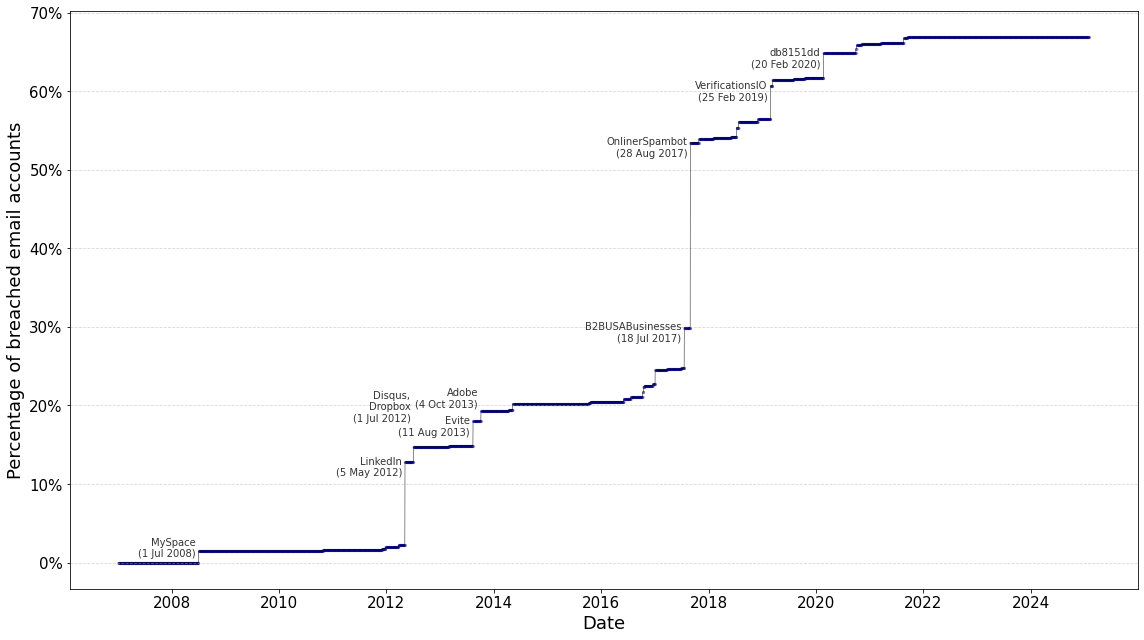

In [43]:
_scale = 1
_aspect_ratio = (16, 9)
figsize = tuple(k * _scale for k in _aspect_ratio)
_, ax = plt.subplots(figsize=figsize)

plt.plot(
    df_dates_subset["date"],
    df_dates_subset["pr"],
    color="0",
    linestyle="-",
    lw=0.5,
    alpha=0.9,
)
plt.scatter(
    df_dates_subset["date"],
    df_dates_subset["pr"],
    color="navy",
    s=5,
    marker="o",
    alpha=0.1,
)

# ============================================================================


def percentage_formatter(x, pos):
    # Convert proportion to percentage format
    return f"{x:.0%}"


ax.yaxis.set_major_formatter(ticker.FuncFormatter(percentage_formatter))


# ============================================================================
# Annotate
ANNOTESIZE = 10
top_jumps = df_dates_subset.nlargest(10, "pr_diff")

for _, row in top_jumps.iterrows():
    breach_date = row["date"] - pd.Timedelta(days=1)  # Take the day before
    breaches = df_hibp.query(f"breachdate=='{breach_date.strftime('%Y-%m-%d')}'")[
        "name"
    ].tolist()
    if breaches:
        breach_label = ",\n".join(breaches)
    else:
        breach_label = "Unknown Breach"
    #     print(breaches)
    #     _LINESTYLE = dict(x=breach_date, color="maroon", linestyle="--", linewidth=1.5, alpha=.5,)
    #     ax.axvline(**_LINESTYLE)
    if breach_label == "Disqus,\nDropbox":
        _ypad = 0.03
    elif breach_label == "Adobe":
        _ypad = 0.003
    elif breach_label == "MySpace":
        _ypad = -0.01
    else:
        _ypad = -0.02
    if "CloudPets" not in breach_label:  # string too long
        ax.text(
            # for horizontal padding, dont remove timedelta
            row["date"] - pd.Timedelta(days=20),
            row["pr"] + _ypad,
            f"{breach_label}\n({breach_date.strftime('%-d %b %Y')})",
            color=".2",
            fontsize=ANNOTESIZE,
            ha="right",
            va="bottom",
        )

# ============================================================================
plt.xlabel("Date", fontsize=18)
plt.ylabel("Percentage of breached accounts", fontsize=18)
ax.tick_params(axis="both", labelsize=15)
ax.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()

save_mpl_fig("../figures/breach_rate_evolution_pre2007_fixedcohort")